In [1]:
import numpy as np 
import matplotlib.pyplot as plt 




In [2]:
def f(x,sigma):
  epsilon = np.random.randn(*x.shape)*sigma
  return 10*np.sin(2*np.pi*x) + epsilon

  

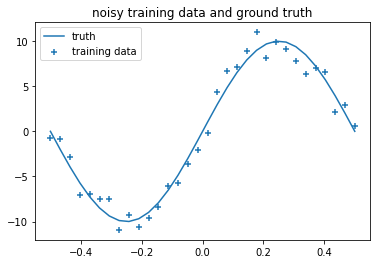

In [3]:
train_size = 32
noise = 1.0 

X = np.linspace(-0.5,0.5,train_size).reshape(-1,1) 
y = f(X,noise) 
y_true = f(X,0.0) 

plt.scatter(X,y,marker='+',label='training data') 
plt.plot(X,y_true,label='truth') 
plt.title('noisy training data and ground truth')
plt.legend()
    


In [4]:
from keras import backend as K 
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf 
import tensorflow_probability as tfp 



In [14]:
class DenseVariational(Layer): 
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,**kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1 
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1*self.prior_sigma_1**2 + 
                                  self.prior_pi_2*self.prior_sigma_2**2)
        super().__init__(**kwargs)

    def compute_output_shape(self,input_shape):
        return input_shape[0],self.units

    def build(self,input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1],self.units),
                                         initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                         trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer = initializers.RandomNormal(stddev=self.init_sigma),
                                       trainable=True)

        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1],self.units,),
                                          initializer = initializers.constant(0.0),
                                          trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer = initializers.constant(0.0),
                                        trainable=True)

        super().build(input_shape)

    
    def call(self,inputs,**kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma*tf.random.normal(self.kernel_mu.shape)
        
        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma*tf.random.normal(self.bias_mu.shape)
        
        self.add_loss(self.kl_loss(kernel,self.kernel_mu,kernel_sigma)+
                      self.kl_loss(bias,self.bias_mu,bias_sigma))
        
        return self.activation(K.dot(inputs,kernel)+bias)
    
    def kl_loss(self,W,mu,sigma):
        variational_dist = tfp.distributions.Normal(mu,sigma)
        return self.kl_weight*K.sum(variational_dist.log_prob(W)-self.log_prior_prob(W))
    
    
    def log_prior_prob(self,W):
        comp_1_dist = tfp.distributions.Normal(0.0,self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0,self.prior_sigma_2)
        return K.log(self.prior_pi_1*comp_1_dist.prob(W) + 
                     self.prior_pi_2*comp_2_dist.prob(W))

In [16]:
import warnings 
warnings.filterwarnings('ignore') 

from keras.layers import Input
from keras.models import Model


In [17]:
batch_size = train_size 
num_batches = train_size / batch_size 

kl_weight = 1.0 / num_batches 

prior_params = {
    'prior_sigma_1':1.5,
    'prior_sigma_2':0.1,
    'prior_pi':0.5
}




In [18]:
x_in = Input(shape=(1,))
x = DenseVariational(20,kl_weight,**prior_params,activation='relu')(x_in)
x = DenseVariational(20,kl_weight,**prior_params,activation='relu')(x)
x = DenseVariational(1,kl_weight,**prior_params)(x) 

model = Model(x_in,x) 



In [19]:
from keras import callbacks, optimizers 

def neg_log_likelihood(y_obs,y_pred,sigma=noise):
  dist = tfp.distributions.Normal(loc=y_pred,scale=sigma)
  return K.sum(-dist.log_prob(y_obs)) 

In [20]:
model.compile(loss=neg_log_likelihood,optimizer=optimizers.Adam(lr=0.08),metrics=['mse']) 
model.fit(X,y,batch_size,epochs=1500,verbose=0) 




100%|██████████| 500/500 [00:30<00:00, 16.54it/s]


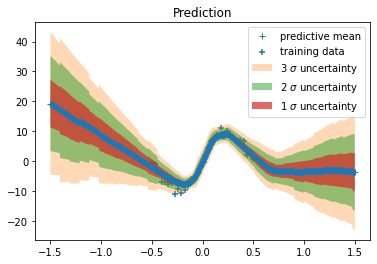

In [22]:
import tqdm 

x_test = np.linspace(-1.5,1.5,1000).reshape(-1,1)
y_pred_list = [] 

for i in tqdm.tqdm(range(500)):
  y_pred = model.predict(x_test) 
  y_pred_list.append(y_pred) 

y_preds = np.concatenate(y_pred_list,axis=1) 

y_mean = np.mean(y_preds,axis=1) 
y_sigma = np.std(y_preds,axis=1) 

plt.plot(x_test,y_mean,'+',label='predictive mean')
plt.scatter(X,y,marker='+',label='training data') 

plt.fill_between(x_test.ravel(),
                 y_mean + 3*y_sigma,
                 y_mean - 3*y_sigma,
                 alpha=0.3,label=r'3 $\sigma$ uncertainty')


plt.fill_between(x_test.ravel(),
                 y_mean + 2*y_sigma,
                 y_mean - 2*y_sigma,
                 alpha=0.5,label=r'2 $\sigma$ uncertainty')



plt.fill_between(x_test.ravel(),
                 y_mean + 1*y_sigma,
                 y_mean - 1*y_sigma,
                 alpha=0.7,label=r'1 $\sigma$ uncertainty')



plt.title('Prediction')
plt.legend()
